In [128]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [129]:
words = open("names.txt", "r").read().splitlines()
print(len(words))
print(max(len(w) for w in words), min(len(w) for w in words))
print(words[:3])

32033
15 2
['emma', 'olivia', 'ava']


In [130]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [131]:
import random
random.seed(42)
random.shuffle(words)

In [132]:
block_size = 8 # amount of previous characters to determine next

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print("".join(itos[i] for i in context), "---->", itos[ix])
            context = context[1:] + [ix] # crop context and append next character

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [133]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [134]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim = True)
            xvar = x.var(dim, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize
        self.out = self.gamma * xhat + self.beta # allow for neural network to change normalization

        # update
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
        
    def parameters(self):
        return []

class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []

class Sequential:
    
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [135]:
torch.manual_seed(42)

In [136]:
n_embd = 20
n_hidden = 200
#g = torch.Generator().manual_seed(2147483647)

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
for p in parameters:
    p.requires_grad = True
print(sum(p.nelement() for p in parameters))

175167


In [137]:
max_steps = 200000
batch_size = 32
losses = []
losses_dev = []

for i in range(max_steps):
    for layer in model.layers:
            layer.training = True

    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # current batch

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    losses.append(loss.log10().item())

    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

        for layer in model.layers:
            layer.training = False

        current_loss_dev = []
        
        for _ in range(100):
            ix = torch.randint(0, Xdev.shape[0], (batch_size,))
            Xb, Yb = Xdev[ix], Ydev[ix]

            logits = model(Xb)
            loss_dev = F.cross_entropy(logits, Yb)

            current_loss_dev.append(loss_dev.log10().item())
        
        losses_dev.append(torch.mean(torch.tensor(current_loss_dev)))


      0/ 200000: 3.2988
  10000/ 200000: 2.3513
  20000/ 200000: 2.1119
  30000/ 200000: 2.0467
  40000/ 200000: 1.9654
  50000/ 200000: 1.7599
  60000/ 200000: 1.7109
  70000/ 200000: 2.1082
  80000/ 200000: 1.9993
  90000/ 200000: 2.0818
 100000/ 200000: 1.5904
 110000/ 200000: 1.7429
 120000/ 200000: 1.8621
 130000/ 200000: 1.8689
 140000/ 200000: 1.8802
 150000/ 200000: 1.9173
 160000/ 200000: 1.9154
 170000/ 200000: 2.0485
 180000/ 200000: 1.5061
 190000/ 200000: 2.0224


## Performance:
- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train: 1.999, val 2.075
- flat -> hierarchical (22K params): train 1.941, val 2.029
- fix batchnorm bug: train 1.912, val 2.022
- scale up the network: n_embd 24, n_hidden 128 (175K params): train 1.793, val 2.01

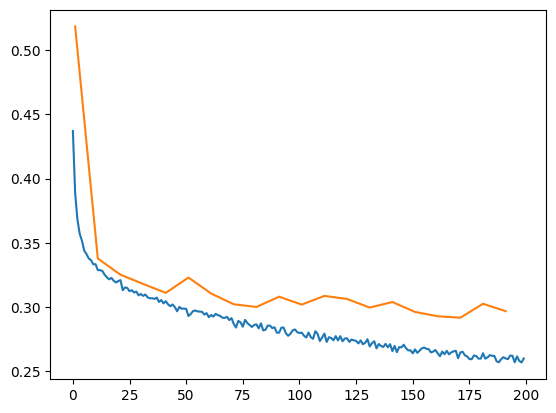

In [138]:
plt.plot(torch.tensor(losses).view(-1, 1000).mean(1))
plt.plot(torch.arange(1,200, 10),losses_dev)

In [139]:
for layer in model.layers:
    layer.training = False

In [140]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7939777374267578
val 2.0136537551879883


In [ ]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

git.
rovanna.
asper.
dvmaleein.
corder.
nora.
isann.
ceven.
nei.
khayse.
emilehair.
myla.
sasen.
sensellu.
genny.
imalb.
trayler.
anaha.
tayutury.
jonny.
